<a href="https://colab.research.google.com/github/michalshavitNYU/michalshavitnyu.github.io/blob/master/Spatiotemporal_from_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your movie inside Google Drive
# Example:
pathmovie = "/content/drive/MyDrive/IMG_4832.mov"

Nfft = 95   # number of frames per FFT chunk (same as MATLAB)

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---- Open video, get basic info ----
cap = cv2.VideoCapture(pathmovie)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video file: {pathmovie}")

fps = cap.get(cv2.CAP_PROP_FPS)
Nim = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
Ni  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
Nj  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

print(f"Frames: {Nim}, size: {Ni} x {Nj}, fps: {fps}")

N = Nim // Nfft
print("Number of chunks =", N)

Framet = np.zeros((Ni, Nj, Nfft), dtype=np.float32)

# Hann windows (time and 2D spatial)
hi = np.hanning(Ni)
hj = np.hanning(Nj)
ht = np.hanning(Nfft)
hs = hi[:,None] * hj[None,:]   # spatial window

sp = None

for j in range(N):
    print(f"{j+1} / {N}")

    for i in range(Nfft):
        ret, frame = cap.read()
        if not ret:
            raise RuntimeError("Unexpected end of video")

        # Single color channel like MATLAB `Frame(:,:,1)`
        gray = frame[:,:,0].astype(np.float32)

        # subtract mean and apply spatial + time windows
        Framet[:,:,i] = (gray - gray.mean()) * hs * ht[i]

    F = np.fft.fftn(Framet, axes=(0,1,2))
    P = np.abs(F)**2

    sp = P if sp is None else sp + P

sp = sp / N
cap.release()


Frames: 219, size: 488 x 1918, fps: 29.993152248345126
Number of chunks = 2
1 / 2
2 / 2


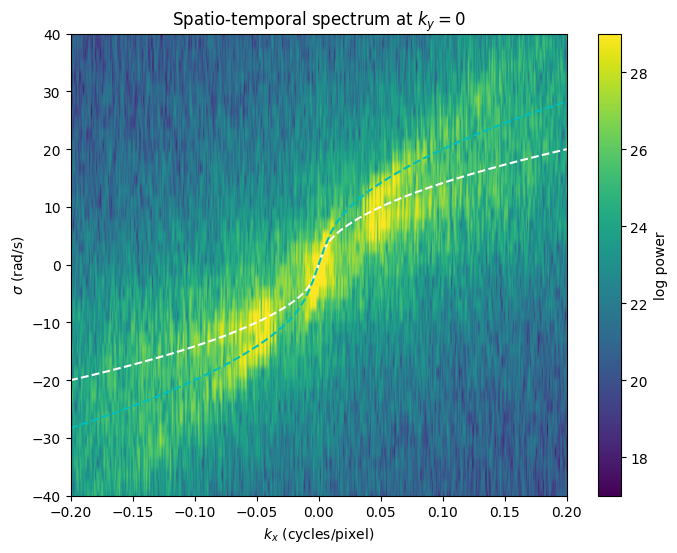

In [6]:
# Frequency axis
f = (np.arange(-Nfft/2, Nfft/2) / Nfft) * fps
sigma = 2*np.pi*f

# Spatial wavenumbers (cycles/pixel)
kx = (np.arange(-Nj/2, Nj/2) / Nj)
ky = (np.arange(-Ni/2, Ni/2) / Ni)

# Center spectrum
spc = np.fft.fftshift(sp,(0,1,2))

# Find ky ≈ 0 index
ky0 = np.argmin(np.abs(ky))

# Slice: kx-sigma plane
C = np.log(spc[ky0,:,:] + 1e-12)   # (kx,sigma)

plt.figure(figsize=(8,6))
plt.imshow(C.T,
           extent=[kx[0],kx[-1],sigma[0],sigma[-1]],
           origin='lower',aspect='auto')

plt.xlabel("$k_x$ (cycles/pixel)")
plt.ylabel("$\\sigma$ (rad/s)")
plt.title("Spatio-temporal spectrum at $k_y=0$")
plt.colorbar(label="log power")
plt.clim(17,29)        # color bar

plt.ylim([-40,40])
plt.xlim([-0.2,0.2])

# Optional dispersion curves like your script
kabs = np.abs(kx)
sig1 = np.sign(kx)*np.sqrt(np.abs(2000*kx)*np.tanh(np.abs(200*kx))) # Finite-depth surface gravity wave dispersion (g, H chosen arbitrarily).
sig3 = np.sign(kx)*np.sqrt(np.abs(4000*kx)*np.tanh(np.abs(100*kx)))
plt.plot(kx,sig1,'w--')
plt.plot(kx,sig3,'c--')

plt.show()
